## Project

loans.csv contains loan applications created on 2017-12-10 with fields:

1.  Loan amount
2.  Address
3.  Created at — timestamp the loan was created
4.  Funded at — timestamp the loan was funded at (no value if the loan never funded)

## Part 1
We want to understand how users "convert" from loan application to funded loan.

1.  How does the conversion rate change over time? Are we doing better or worse? In particular, what about loans from the last 30 or last 60 days?
2.  What about the time to conversion? Are people converting faster or does it take longer?

## Part 2
You can break down loans into either conforming or jumbo. In almost all cases, it's based on the loan amount compared to the county's loan limit. If the loan amount is above the county loan limit, it's a jumbo loan. These loans have very different underwriting criteria and often slightly higher interest rates.

You can download the county loan limits from the FHFA website. Use the 2017 limits. Assume that all properties in the data set have 1 unit.
To go from addresses to counties, use FIPS codee from FFIEC. 

1.  What is the conversion rate from loan application to fund, broken down by conforming vs jumbo?
2.  How does it vary over time?
3.  How much worse is the conversion rate for jumbo, controlling for the loan amount?
4.  What about states? Are there particular states where it looks like our Jumbo has much worse conversion?

Presentation of results can be found in loan_analytics.pdf

In [1]:
%matplotlib inline
from IPython.display import display, HTML, Javascript, clear_output, Image
import pandas as pd
import numpy as np
from scipy.stats import mstats
import scipy.special
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import time
from collections import defaultdict
import os
import sys
import re
import json
from joblib import Parallel, delayed
import requests
from lxml import html
import pickle
from lifelines import KaplanMeierFitter
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
import pdb
import warnings

warnings.simplefilter('ignore')
sns.set(style='whitegrid', palette='muted')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '{0:4f}'.format(x))

np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})

In [2]:
def get_fips_code(address):
    #get FIPS code based on full address using FFIEC 'API'
    curl = '''
    curl -k POST \
    --header "Accept:application/json" \
    --header "Content-Type:application/json" \
    --data '{{"sSingleLine":"{0}", "iCensusYear":"2017"}}' \
    https://geomap.ffiec.gov/FFIECGeocMap/GeocodeMap1.aspx/GetGeocodeData
    '''.format(address)

    response = os.popen(curl).read()
    
    try:
        fips_result = json.loads(response)
        fips = '{0}{1}'.format(fips_result['d']['sStateCode'], fips_result['d']['sCountyCode'])
    except:
        fips = ''
        
    #if FFIEC doesn't return a value, scrape FIPS by zip code
    if fips == '':
        zipcode = address[-5:]
        url = 'https://www.zip-codes.com/zip-code/{0}/zip-code-{0}.asp'.format(zipcode)
        page = requests.get(url)
        tree = html.fromstring(page.content)
        state_fips_elements = tree.xpath("//span[contains(text(), 'State FIPS')]/../following-sibling::td")
        state_fips = state_fips_elements[0].text
        county_fips_elements = tree.xpath("//span[contains(text(), 'County FIPS')]/../following-sibling::td")
        county_fips = county_fips_elements[0].text
        fips = state_fips + county_fips
        
    return fips

In [3]:
def wilson_ci(pos, tot, p=0.95):
    """Binomial proportion confidence interval
    confidence interval for the probability of success calculated from 
    the outcome of a series of success–failure experiments"""
    if tot > 0:
        z = scipy.special.erfinv(p) * np.sqrt(2)
        z2 = z * z
        center = (pos + z2/2) / (tot + z2)
        width2 = (z / (tot + z2)) * np.sqrt(pos * (tot - pos) / tot + z2 / 4)
        return (np.clip(center - width2, 0, 1), np.clip(center + width2, 0, 1))
    else:
        return (0, 0)

In [4]:
def ordinal(value):
    return '{0:d}{1:s}'.format(value, 'th' if ((value >= 11 and value <= 19) or value == 0) else \
                               'tsnrhtdd'[(value / 10 % 10 != 1) * (value % 10 < 4) * (value % 10)::4])

In [5]:
def logit_predict_with_ci(model, X):
    proba = model.predict(X)
    cov = model.cov_params()
    gradient = (proba * (1 - proba) * X.T).T
    std_errors = np.array([np.sqrt(np.dot(np.dot(g, cov), g)) for g in gradient])
    c = 1.96
    upper = np.maximum(0, np.minimum(1, proba + std_errors * c))
    lower = np.maximum(0, np.minimum(1, proba - std_errors * c))
    
    return (lower, proba, upper)

In [6]:
describe_percentiles=[0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1]
rolling_window_days = [30, 60]
rolling_window_colors = ['b', 'r']
process_days_pctiles = [0.25, 0.50, 0.75]
loan_types = ['Conforming', 'Jumbo']
drop_state = 'AZ'

In [7]:
df_loans = pd.read_csv('/Users/michael.gerstein/mag/ref/port/loans.csv', names=['loan_amount', 'address', 'created_at', 'funded_at'], header=None)

In [8]:
df_loans.created_at = df_loans.created_at.apply(lambda x: datetime.strptime(x[:10], '%Y-%m-%d'))
df_loans.funded_at = df_loans.funded_at.fillna('1970-01-01')
df_loans.funded_at = df_loans.funded_at.apply(lambda x: datetime.strptime(x[:10], '%Y-%m-%d'))

In [9]:
#loan file create date is 2017-12-10 so removing events that occur after this date
df_loans = df_loans[(df_loans.created_at <= datetime(2017, 12, 10)) & (df_loans.funded_at <= datetime(2017, 12, 10))]

In [10]:
df_loans['days_since_created'] = datetime(2017, 12, 10) - df_loans.created_at
df_loans.days_since_created = df_loans.days_since_created.apply(lambda x: x.days)
df_loans['processing_days'] = df_loans.funded_at - df_loans.created_at
df_loans.processing_days = df_loans.processing_days.apply(lambda x: -1 if x.days < 0 else x.days)
df_loans['has_converted'] = df_loans.processing_days.apply(lambda x: 0 if x == -1 else 1)
df_loans['zipcode'] = df_loans.address.str.slice(-5, )
df_loans['state'] = df_loans.address.str.slice(-8, -6)

In [11]:
df_loans[df_loans.processing_days != -1].processing_days.describe(percentiles=describe_percentiles)

count   1040.000000
mean      49.140385
std       19.782151
min       16.000000
0%        16.000000
1%        20.000000
5%        26.000000
10%       29.000000
25%       36.000000
50%       45.000000
75%       58.000000
90%       74.000000
95%       83.050000
99%      111.220000
100%     201.000000
max      201.000000
Name: processing_days, dtype: float64

In [12]:
df_loans.loan_amount.describe(percentiles=describe_percentiles)

count       5094.000000
mean      383145.743031
std      1277092.458252
min            9.000000
0%             9.000000
1%         65620.620000
5%        110896.750000
10%       139176.500000
25%       216973.250000
50%       318192.000000
75%       421939.000000
90%       589840.300000
95%       696887.450000
99%      1120304.430000
100%    57762492.000000
max     57762492.000000
Name: loan_amount, dtype: float64

In [13]:
sorted(df_loans.loan_amount.unique(), reverse=False)[:10], sorted(df_loans.loan_amount.unique(), reverse=True)[:10]

([9.0,
  2000.0,
  2001.0,
  5000.0,
  9996.0,
  10000.0,
  11396.0,
  15000.0,
  15420.0,
  17000.0],
 [57762492.0,
  49188823.0,
  48589348.0,
  9545318.0,
  2750000.0,
  2405731.0,
  2150000.0,
  2000000.0,
  1977055.0,
  1973553.0])

In [14]:
#remove likely outliers or inaccurate loan amounts
df_loans = df_loans[(df_loans.loan_amount >= 9995) & \
                    (df_loans.loan_amount <= 9500000)]

In [15]:
#load county limits to determine conforming and jumbo loans
df_fips_limit = pd.read_excel('/Users/michael.gerstein/Downloads/FullCountyLoanLimitList2017_HERA-BASED_FINAL_FLAT.xlsx', sheet_name='GSE Limits',
                              skiprows=[0], header=[0], converters={'FIPS State Code': str, 'FIPS County Code': str})

for col in df_fips_limit.columns:
    df_fips_limit = df_fips_limit.rename(columns={col: col.lower().replace('-', '_').replace(' ', '_')})
    
df_fips_limit['fips'] = df_fips_limit['fips_state_code'].str.cat(df_fips_limit['fips_county_code'], sep='')
df_fips_limit = df_fips_limit.set_index(['fips'])

In [16]:
#parallelize FIPS scrape
#fips_results = Parallel(n_jobs=28, verbose=1)(delayed(get_fips_code)(address) for address in df_loans.address)

#pickled results of address/zip to FIPS so don't have to rerun scrape routine
with open('/Users/michael.gerstein/mag/ref/port/fips.pkl', 'rb') as f:
    fips_results = pickle.load(f)

In [17]:
#append FIPS and loan limit to loans data
df_loans['fips'] = [x[1] for x in fips_results]
df_loans['one_unit_limit'] = df_loans.fips.apply(lambda x: df_fips_limit.loc[x, 'one_unit_limit'] if x in df_fips_limit.index else -1)
df_loans['loan_type'] = df_loans.apply(lambda row: 'Conforming' if row.loan_amount < row.one_unit_limit else 'Jumbo', axis=1)
df_loans['loan_type_bin'] = df_loans.apply(lambda row: 0 if row.loan_amount < row.one_unit_limit else 1, axis=1)

In [18]:
df_loans[(df_loans.processing_days != -1) & 
         (df_loans.loan_type == 'Conforming')].processing_days.describe(percentiles=describe_percentiles)

count   1022.000000
mean      49.040117
std       19.824039
min       16.000000
0%        16.000000
1%        20.000000
5%        26.000000
10%       29.000000
25%       36.000000
50%       45.000000
75%       58.000000
90%       73.000000
95%       83.000000
99%      111.580000
100%     201.000000
max      201.000000
Name: processing_days, dtype: float64

In [19]:
df_loans[(df_loans.processing_days != -1) & 
         (df_loans.loan_type == 'Jumbo')].processing_days.describe(percentiles=describe_percentiles)

count   18.000000
mean    54.833333
std     16.727047
min     31.000000
0%      31.000000
1%      32.190000
5%      36.950000
10%     38.700000
25%     40.750000
50%     50.500000
75%     64.750000
90%     76.200000
95%     80.800000
99%     88.960000
100%    91.000000
max     91.000000
Name: processing_days, dtype: float64

In [20]:
#cap life of conforming loan application at 112 days (only 1% of converted applications occur after 112 days)
df_loans['duration'] = df_loans.apply(lambda row: row.processing_days if row.has_converted == 1 else min(112, row.days_since_created), axis=1)

In [21]:
#use Kaplan Meier to calculate conversion rates because of right censored data
#loan conversion can occur anytime but usually has significant lag time
#standard calculation of conversion rates will understate in more recent periods
#because of outstanding applications
kmf = KaplanMeierFitter()

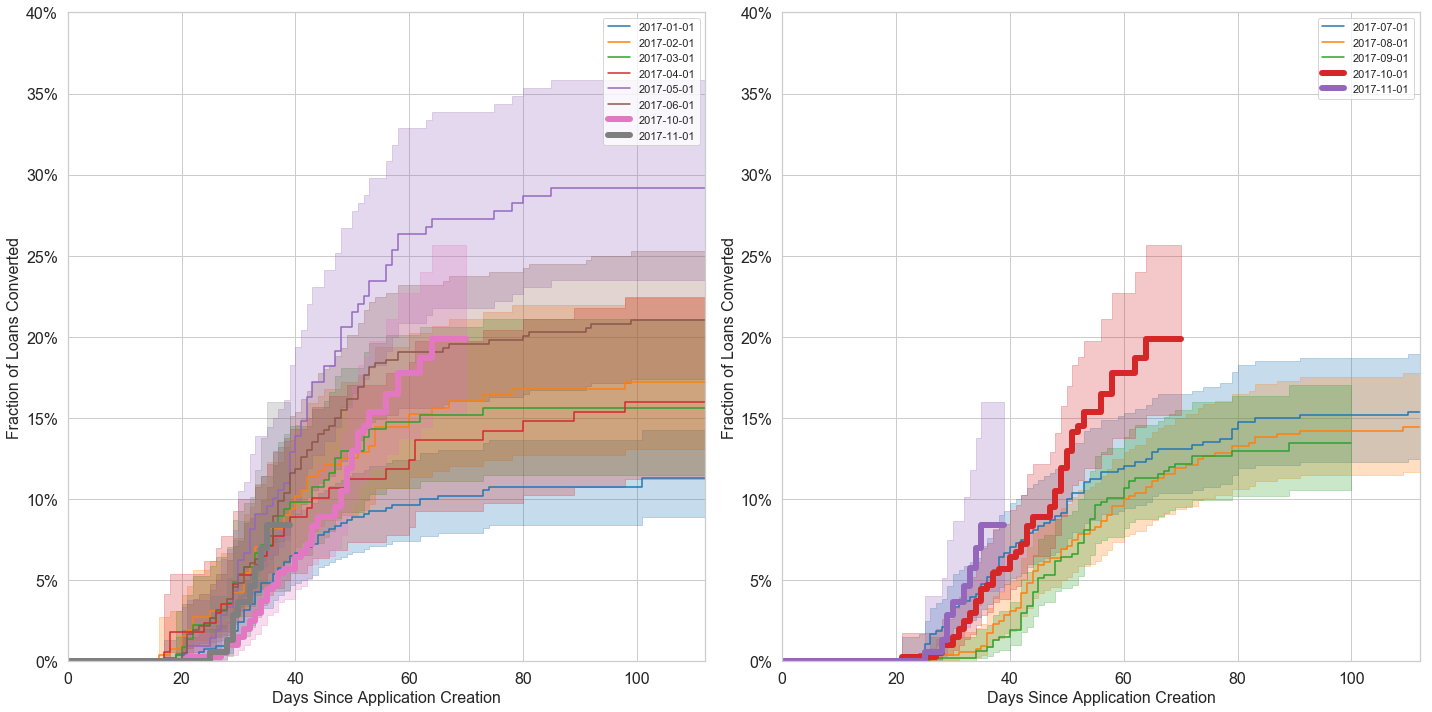

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(20, 10) 

plot_months = [dt for dt in pd.date_range('2017-01-01', '2017-11-01', freq='MS')]
plot_months_a = plot_months[0:6] + plot_months[-2:]
plot_months_b = plot_months[6:]
cmap = mpl.cm.tab10

for j, plot_months_slice in enumerate([plot_months_a, plot_months_b]):
    my_ax = ax[j]
    
    for i, dt in enumerate(plot_months_slice):
        df_temp = df_loans[(df_loans.created_at >= dt) & (df_loans.created_at < dt + relativedelta(months=1))]

        if df_temp.empty:
            continue

        kmf.fit(df_temp.duration, event_observed=df_temp.has_converted, label='{0}'.format(dt.strftime('%Y-%m-%d')))
        kmf.plot(ci_show=True, invert_y_axis=True, ax=my_ax)
        my_ax.get_lines()[-1].set_color(cmap(i))
        my_ax.collections[-1].set_edgecolor(cmap(i))
        my_ax.collections[-1].set_facecolor(cmap(i))
        
    my_ax.get_lines()[-1].set_linewidth(4 * my_ax.get_lines()[-1].get_linewidth())
    my_ax.get_lines()[-2].set_linewidth(4 * my_ax.get_lines()[-2].get_linewidth())
    my_ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: '{0:.0f}%'.format((1-x)*100)))
    my_ax.tick_params(labelsize=16, axis='both')
    my_ax.set_xlabel('Days Since Application Creation', fontdict={'fontsize': 16})
    my_ax.set_ylabel('Fraction of Loans Converted', fontdict={'fontsize': 16})
    my_ax.set_ylim([1, .60])
    my_ax.set_xlim([0, 112])
    my_ax.legend(my_ax.get_lines(), [line._label for line in my_ax.get_lines()])

plt.tight_layout()
plt.show()

In [23]:
df_loans_convert = df_loans.groupby(['created_at']).agg({'loan_amount': 'count', 'has_converted': 'sum'})

In [24]:
operation_dates = pd.date_range(df_loans.created_at.min(), df_loans.created_at.max())
df_loans_convert = df_loans_convert.reindex(operation_dates, fill_value=0)

In [25]:
#standard calculation of conversion rate 
#based on rolling 30 and 60 day windows from application create date
#includes 95% confidence interval of calculated conversion rate
for period in rolling_window_days:
    df_loans_convert['prev_{0:d}_loans'.format(period)] = df_loans_convert.loan_amount.rolling(period, min_periods=1).sum()
    df_loans_convert['prev_{0:d}_converted'.format(period)] = df_loans_convert.has_converted.rolling(period, min_periods=1).sum()
    df_loans_convert['prev_{0:d}_conversion_rate'.format(period)] = df_loans_convert['prev_{0:d}_converted'.format(period)] / df_loans_convert['prev_{0:d}_loans'.format(period)]
    df_loans_convert['prev_{0:d}_ci_bot'.format(period)] = 0
    df_loans_convert['prev_{0:d}_ci_top'.format(period)] = 0
    df_loans_convert.ix[:, ['prev_{0:d}_ci_bot'.format(period), 'prev_{0:d}_ci_top'.format(period)]] = df_loans_convert.apply(lambda row: wilson_ci(row['prev_{0:d}_converted'.format(period)], \
                                                                                                                                                    row['prev_{0:d}_loans'.format(period)]), axis=1).tolist()

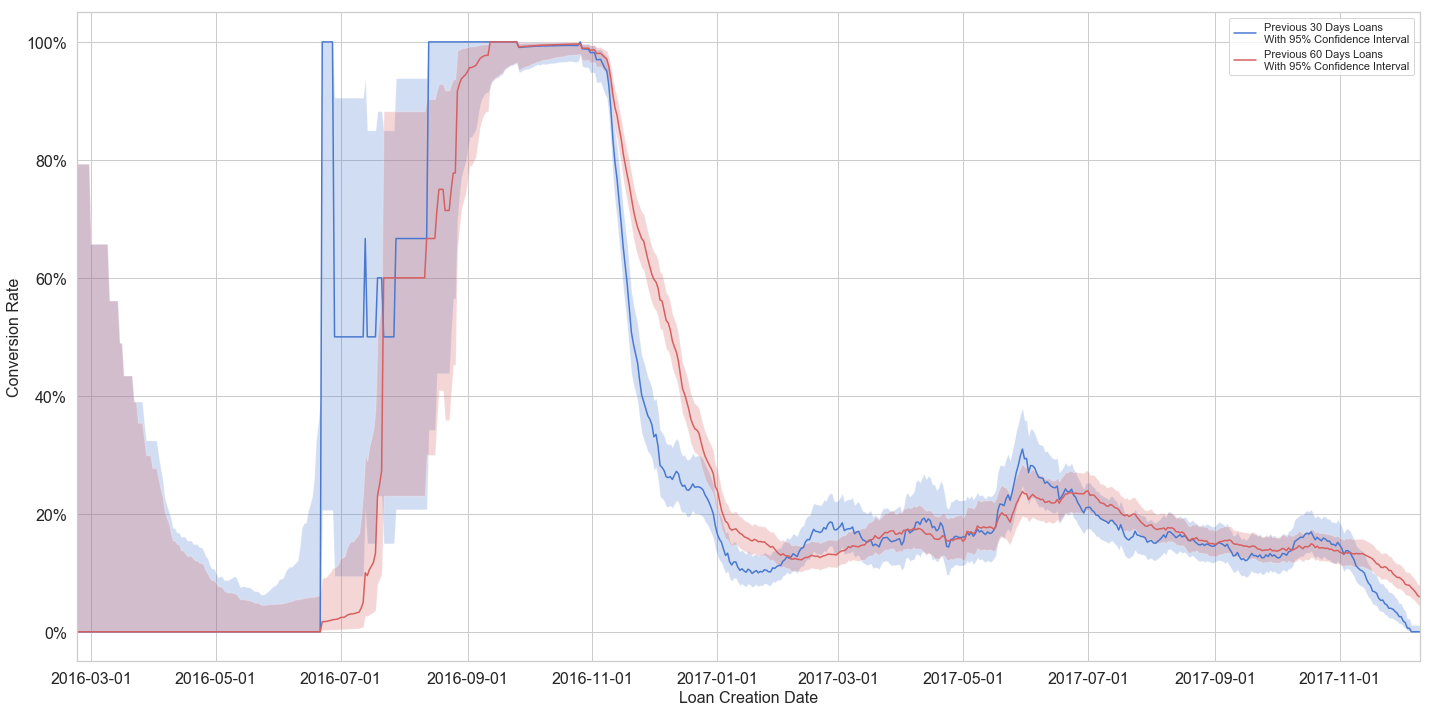

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(20, 10)

legend_elements = []

for i, period in enumerate(rolling_window_days):
    ax.plot(df_loans_convert.index, df_loans_convert['prev_{0:d}_conversion_rate'.format(period)], c=rolling_window_colors[i])
    ax.fill_between(df_loans_convert.index, df_loans_convert['prev_{0:d}_ci_bot'.format(period)], 
                    df_loans_convert['prev_{0:d}_ci_top'.format(period)], facecolor=rolling_window_colors[i], alpha=0.25)
    legend_elements.append(Line2D([0], [0], color=rolling_window_colors[i], 
                                  label='Previous {0:d} Days Loans\nWith 95% Confidence Interval'.format(period), 
                                  markerfacecolor=rolling_window_colors[i]))
    
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: '{0:.0f}%'.format(x*100)))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.tick_params(labelsize=16, axis='both')
ax.set_xlabel('Loan Creation Date', fontdict={'fontsize': 16})
ax.set_ylabel('Conversion Rate', fontdict={'fontsize': 16})
ax.legend(handles=legend_elements, loc='best')
ax.set_xlim([min(df_loans_convert.index), max(df_loans_convert.index)])

plt.tight_layout()
plt.show()

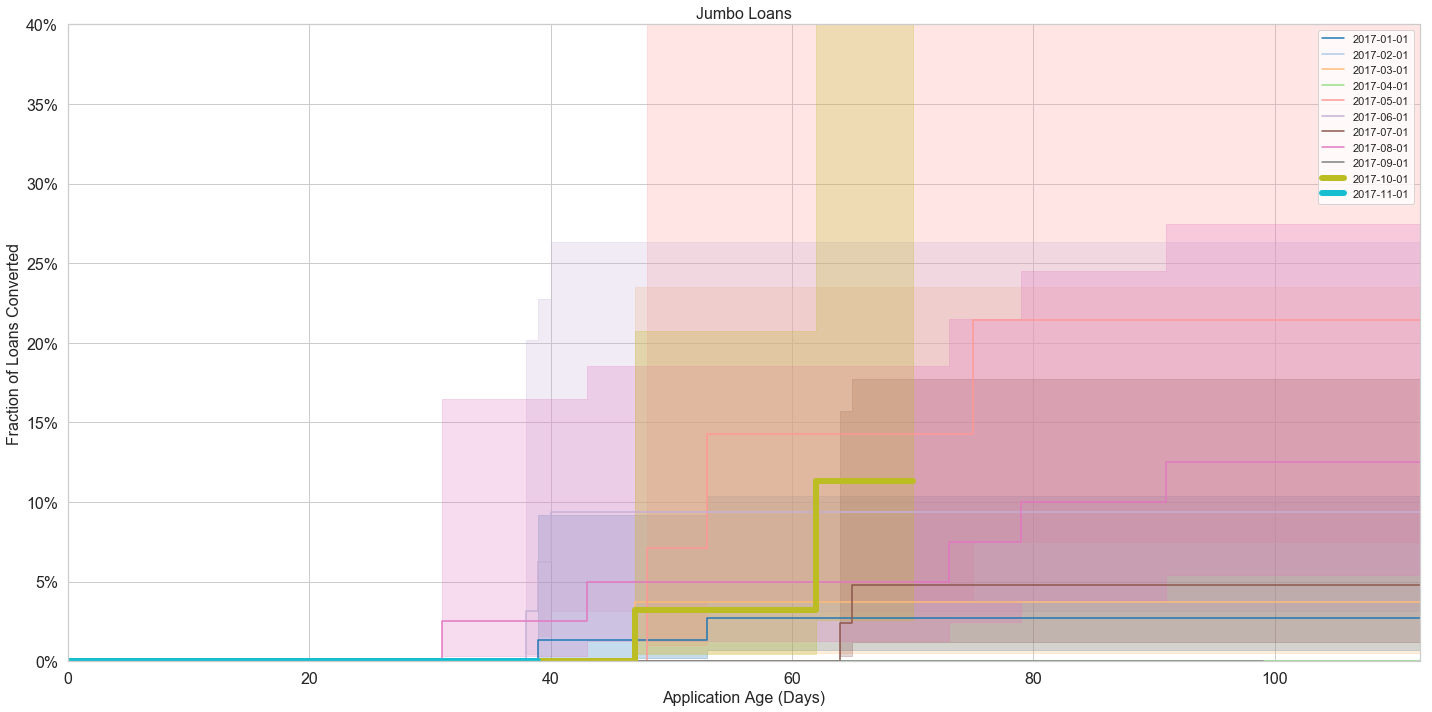

In [27]:
#Kaplan Meier separate for conforming and jumbo loans
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(20, 10) 
cmap = mpl.cm.tab20

plot_months = pd.date_range('2017-01-01', '2017-11-01', freq='MS')

for j, loan_type in enumerate(loan_types[1:]):
    #my_ax = ax[j]
    my_ax = ax
    
    for i, dt in enumerate(plot_months):
        df_temp = df_loans[(df_loans.created_at >= dt) & (df_loans.created_at < dt + relativedelta(months=1)) & (df_loans.loan_type == loan_type)]

        if df_temp.empty:
            continue

        kmf.fit(df_temp.duration, event_observed=df_temp.has_converted, label='{0}'.format(dt.strftime('%Y-%m-%d')))
        kmf.plot(ci_show=True, invert_y_axis=True, ax=my_ax)
        my_ax.get_lines()[-1].set_color(cmap(i / len(plot_months)))
        my_ax.collections[-1].set_edgecolor(cmap(i / len(plot_months)))
        my_ax.collections[-1].set_facecolor(cmap(i / len(plot_months)))

    my_ax.get_lines()[-1].set_linewidth(4 * my_ax.get_lines()[-1].get_linewidth())
    my_ax.get_lines()[-2].set_linewidth(4 * my_ax.get_lines()[-2].get_linewidth())
    my_ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: '{0:.0f}%'.format((1-x)*100)))
    my_ax.tick_params(labelsize=16, axis='both')
    my_ax.set_title('{0} Loans'.format(loan_type), fontdict={'fontsize': 16})
    my_ax.set_xlabel('Application Age (Days)', fontdict={'fontsize': 16})
    my_ax.set_ylabel('Fraction of Loans Converted', fontdict={'fontsize': 16})
    my_ax.set_ylim([1, .60])
    my_ax.set_xlim([0, 112])
    my_ax.legend(my_ax.get_lines(), [line._label for line in my_ax.get_lines()])

plt.tight_layout()
plt.show()

In [28]:
df_loans_convert_type = df_loans.groupby(['created_at', 'loan_type'], as_index=False).agg({'loan_amount': 'count', 'has_converted': 'sum'})

In [29]:
#standard calculation of conversion rate 
#based on rolling 30 and 60 day windows from application create date
#includes 95% confidence interval of calculated conversion rate
df_temps = []

for loan_type in loan_types:
    df_temp = df_loans_convert_type[df_loans_convert_type.loan_type == loan_type].set_index(['created_at']).reindex(operation_dates, fill_value=0)
    df_temp.loan_type = loan_type
    
    for period in rolling_window_days:
        df_temp['prev_{0:d}_loans'.format(period)] = df_temp.loan_amount.rolling(period, min_periods=1).sum()
        df_temp['prev_{0:d}_converted'.format(period)] = df_temp.has_converted.rolling(period, min_periods=1).sum()
        df_temp['prev_{0:d}_conversion_rate'.format(period)] = df_temp['prev_{0:d}_converted'.format(period)] / np.maximum(1, df_temp['prev_{0:d}_loans'.format(period)])
        df_temp['prev_{0:d}_ci_bot'.format(period)] = 0
        df_temp['prev_{0:d}_ci_top'.format(period)] = 0
        df_temp.ix[:, ['prev_{0:d}_ci_bot'.format(period), 'prev_{0:d}_ci_top'.format(period)]] = df_temp.apply(lambda row: wilson_ci(row['prev_{0:d}_converted'.format(period)], \
                                                                                                                                      row['prev_{0:d}_loans'.format(period)]), axis=1).tolist()
    
    df_temps.append(df_temp)

df_loans_convert_type = pd.concat(df_temps)

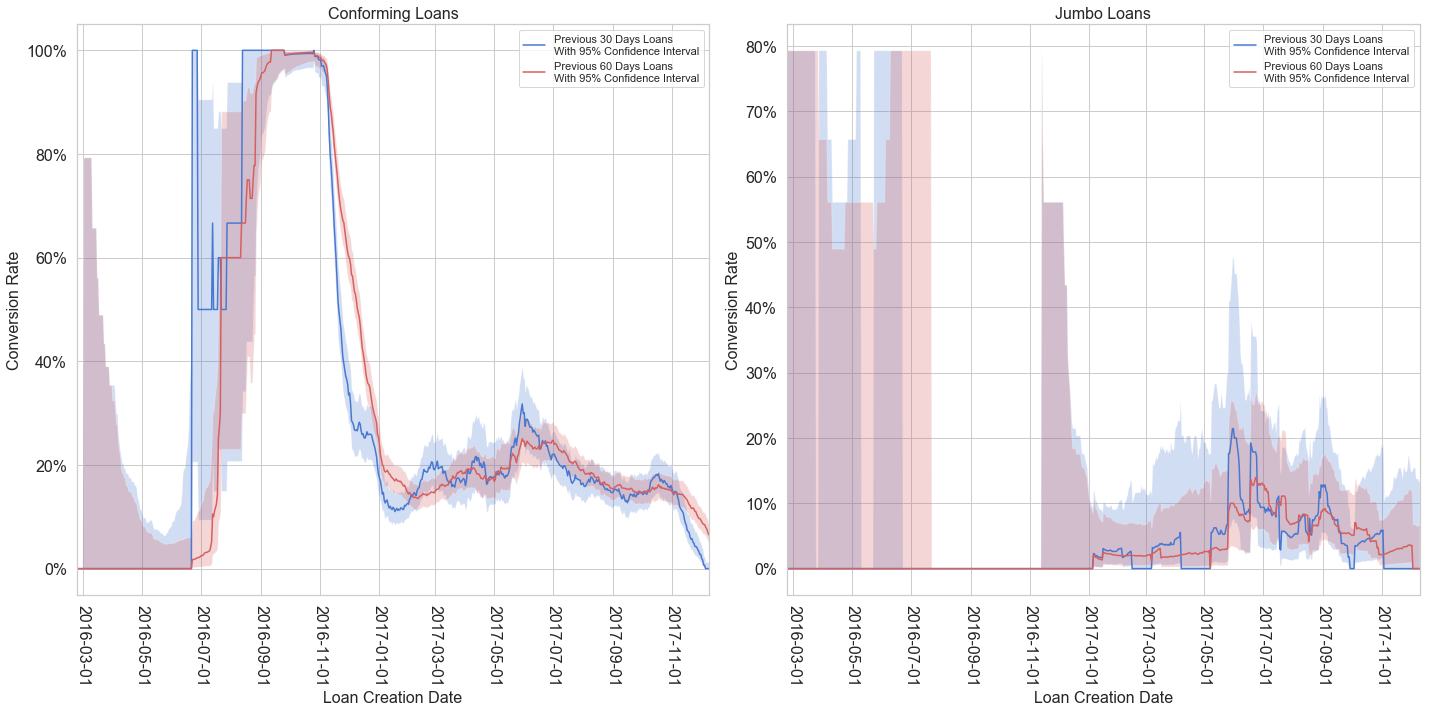

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(20, 10)

for i, loan_type in enumerate(loan_types):
    my_ax = ax[i]
    
    df_temp = df_loans_convert_type[df_loans_convert_type.loan_type == loan_type]
    
    legend_elements = []
    
    for i, period in enumerate(rolling_window_days):
        my_ax.plot(df_temp.index, df_temp['prev_{0:d}_conversion_rate'.format(period)], c=rolling_window_colors[i])
        my_ax.fill_between(df_temp.index, df_temp['prev_{0:d}_ci_bot'.format(period)], 
                        df_temp['prev_{0:d}_ci_top'.format(period)], facecolor=rolling_window_colors[i], alpha=0.25)
        legend_elements.append(Line2D([0], [0], color=rolling_window_colors[i], label='Previous {0:d} Days Loans\nWith 95% Confidence Interval'.format(period), markerfacecolor=rolling_window_colors[i]))

    my_ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: '{0:.0f}%'.format(x*100)))
    my_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    my_ax.tick_params(labelsize=16, axis='both')
    my_ax.tick_params(rotation=-90, axis='x')
    my_ax.set_title('{0} Loans'.format(loan_type), fontdict={'fontsize': 16})
    my_ax.set_xlabel('Loan Creation Date', fontdict={'fontsize': 16})
    my_ax.set_ylabel('Conversion Rate', fontdict={'fontsize': 16})
    my_ax.legend(handles=legend_elements, loc='best')
    my_ax.set_xlim([min(df_loans_convert.index), max(df_loans_convert.index)])

plt.tight_layout()
plt.show()

In [31]:
def get_rolling_pctile(df, start_dt, end_dt, date_col, pctile_col, pctile):
    if df[(df[date_col] >= start_dt) & (df[date_col] <= end_dt)].empty:
        return -1
    else:
        return df[(df[date_col] >= start_dt) & (df[date_col] <= end_dt)][pctile_col].quantile(pctile)

v_get_rolling_pctile = np.vectorize(get_rolling_pctile, excluded=[0, 3, 4, 5])

In [32]:
#run into the same issue as with conversion rates when looking at how long it takes to process an application
#the data is right censored as some applications are still being processed
#as a result, processing time may be understated for most recent periods
#look at interquartile range (25th-75th percentiles)
#based on rolling 30 and 60 day windows from application create date
for i, period in enumerate(rolling_window_days):
    df_temp = df_loans[(df_loans.has_converted > -1)] #include all loan applications
    df_temp = df_temp.groupby(['created_at']).agg({'loan_amount': 'count'})
    df_temp = df_temp.reindex(operation_dates, fill_value=0).reset_index().rename(columns={'index': 'created_at'})
    df_temp['start_dt_{0:d}'.format(period)] = df_temp.created_at - timedelta(days=period)
    
    for pctile in process_days_pctiles:
        df_temp['process_{0}_{1:d}ile'.format(period, int(100 * pctile))] = v_get_rolling_pctile(df_loans[(df_loans.has_converted == 1)], df_temp['start_dt_{0:d}'.format(period)].dt.date, \
                                                                                                 df_temp.created_at.dt.date, 'created_at', 'duration', pctile)
        
    if i == 0:
        df_loans_process = df_temp.copy()
    else:
        df_loans_process = df_loans_process.merge(df_temp, how='inner', left_on='created_at', right_on='created_at', suffixes=('_l', '_r'))
        
        for col in df_loans_process.columns:
            if '_r' in col:
                df_loans_process = df_loans_process.drop([col], axis=1)
            
            if '_l' in col:
                df_loans_process = df_loans_process.rename(columns={col: col.replace('_l', '')})

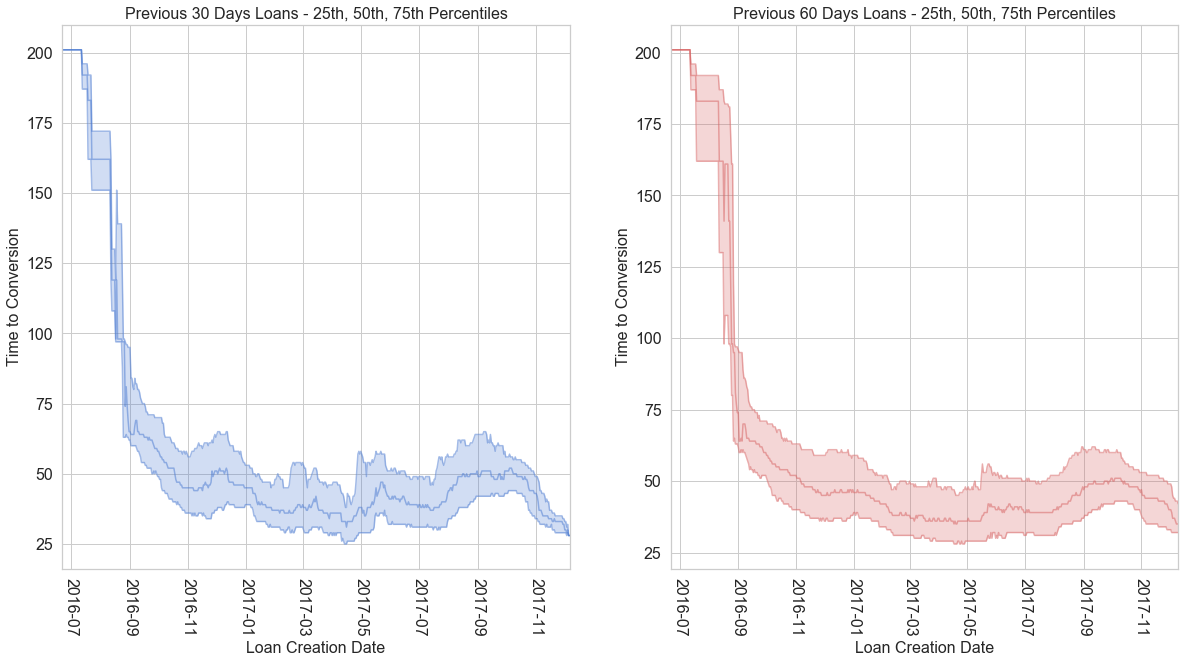

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(20, 10)

for i, period in enumerate(rolling_window_days):
    my_ax = ax[i]

    pctile_cols = [col for col in df_loans_process.columns if '_{0:d}'.format(period) in col]
    df_temp = df_loans_process[~(df_loans_process[pctile_cols] == -1).any(axis=1)]
    
    for pctile in process_days_pctiles:
        my_ax.plot(df_temp.created_at, df_temp['process_{0:d}_{1:d}ile'.format(period, int(100 * pctile))], c=rolling_window_colors[i], alpha=0.5)
 
    my_ax.fill_between(df_temp.set_index(['created_at']).index, df_temp['process_{0:d}_{1:d}ile'.format(period, int(100 * process_days_pctiles[0]))], 
                       df_temp['process_{0:d}_{1:d}ile'.format(period, int(100 * process_days_pctiles[-1]))], facecolor=rolling_window_colors[i], alpha=0.25)

    my_ax.tick_params(labelsize=16, axis='both')
    my_ax.tick_params(rotation=-90, axis='x')
    my_ax.set_title('Previous {0:d} Days Loans - {1} Percentiles'.format(period, ', '.join([ordinal(int(x * 100)) for x in process_days_pctiles])), fontdict={'fontsize': 16})
    my_ax.set_xlabel('Loan Creation Date', fontdict={'fontsize': 16})
    my_ax.set_ylabel('Time to Conversion', fontdict={'fontsize': 16})
    my_ax.set_xlim([min(df_temp.created_at), max(df_temp.created_at)])

plt.show()

In [34]:
#exclude loans in process (> 112 days for conforming, > 88 for jumbo) when getting number of conversions
#and calculating overall conversion rates
df_loans_convert_conform = df_loans[((df_loans.has_converted == 1) & (df_loans.loan_type == 'Conforming')) | 
                                    ((df_loans.has_converted == 0) & (df_loans.days_since_created >= 112) &
                                     (df_loans.loan_type == 'Conforming'))
                                   ].groupby(['loan_type']).agg({'has_converted': 'sum', 'loan_amount': 'count'})
df_loans_convert_conform['conversion_rate'] = df_loans_convert_conform.has_converted / df_loans_convert_conform.loan_amount

df_loans_convert_jumbo = df_loans[((df_loans.has_converted == 1) & (df_loans.loan_type == 'Jumbo')) | 
                                  ((df_loans.has_converted == 0) & (df_loans.days_since_created >= 88) &
                                   (df_loans.loan_type == 'Jumbo'))
                                 ].groupby(['loan_type']).agg({'has_converted': 'sum', 'loan_amount': 'count'})
df_loans_convert_jumbo['conversion_rate'] = df_loans_convert_jumbo.has_converted / df_loans_convert_jumbo.loan_amount

df_loans_convert_conform, df_loans_convert_jumbo

(            has_converted  loan_amount  conversion_rate
 loan_type                                              
 Conforming           1022         3493         0.292585,
            has_converted  loan_amount  conversion_rate
 loan_type                                             
 Jumbo                 18          333         0.054054)

In [35]:
#Build logistic regression model to determine impact of jumbo classification to conversion
#Only consider loans that have converted or loans that have not yet converted that are in the top 1% 
#in days since creation
df_loans_logit = df_loans[(df_loans.has_converted == 1) | 
                          (((df_loans.has_converted == 0) & (df_loans.loan_type == 'Conforming') & (df_loans.days_since_created >= 112)) |
                           ((df_loans.has_converted == 0) & (df_loans.loan_type == 'Jumbo') & (df_loans.days_since_created >= 88)))]

X_type = df_loans_logit[['loan_type_bin']]
X_type = sm.add_constant(X_type)

logit_model_type = sm.Logit(df_loans_logit.has_converted, X_type).fit()
y_pred_type = logit_model_type.predict(X_type)
auc_type = roc_auc_score(df_loans_logit.has_converted, y_pred_type)

print('AUC: {0:.6f}'.format(auc_type))
logit_model_type.summary()

Optimization terminated successfully.
         Current function value: 0.570143
         Iterations 7
AUC: 0.547879


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          has_converted   No. Observations:                 3826
Model:                          Logit   Df Residuals:                     3824
Method:                           MLE   Df Model:                            1
Date:                Fri, 15 Mar 2019   Pseudo R-squ.:                 0.02550
Time:                        17:21:23   Log-Likelihood:                -2181.4
converged:                       True   LL-Null:                       -2238.5
                                        LLR p-value:                 1.190e-26
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.8829      0.037    -23.739      0.000      -0.956      -0.810
loan_type_bin    -1.9793      0.245     -8.073      0.000      -2.460      -1.499
=================================================================================
"""

In [36]:
#Calculate confidence interval of impact on conversion probability given change to jumbo loan
X_pred_conform = X_type[X_type.loan_type_bin == 0].head(1)
X_pred_jumbo = X_type[X_type.loan_type_bin == 1].head(1)

lower_conform, proba_conform, upper_conform = logit_predict_with_ci(logit_model_type, X_pred_conform.values)
lower_jumbo, proba_jumbo, upper_jumbo = logit_predict_with_ci(logit_model_type, X_pred_jumbo.values)

lower_jumbo / upper_conform - 1, upper_jumbo / lower_conform - 1

(array([-0.903252]), array([-0.717686]))

In [37]:
#Model for loan amount and loan type
X_type_amt = df_loans_logit[['loan_type_bin', 'loan_amount']]
X_type_amt = sm.add_constant(X_type_amt)

logit_model_type_amt = sm.Logit(df_loans_logit.has_converted, X_type_amt).fit()
y_pred_type_amt = logit_model_type_amt.predict(X_type_amt)
auc_type_amt = roc_auc_score(df_loans_logit.has_converted, y_pred_type_amt)

print('AUC: {0:.6f}'.format(auc_type_amt))
logit_model_type_amt.summary()

Optimization terminated successfully.
         Current function value: 0.566500
         Iterations 7
AUC: 0.612682


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          has_converted   No. Observations:                 3826
Model:                          Logit   Df Residuals:                     3823
Method:                           MLE   Df Model:                            2
Date:                Fri, 15 Mar 2019   Pseudo R-squ.:                 0.03173
Time:                        17:21:23   Log-Likelihood:                -2167.4
converged:                       True   LL-Null:                       -2238.5
                                        LLR p-value:                 1.422e-31
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.3086      0.089    -14.748      0.000      -1.483      -1.135
loan_type_bin    -2.7265      0.293     -9.294      0.000      -3.302      -2.152
loan_amount     1.33e-06   2.48e-07      5.368      0.000    8.45e-07    1.82e-06
=================================================================================
"""

In [38]:
#Calculate confidence interval of impact on conversion probability given change to jumbo loan given no change in price
X_pred_conform = X_type_amt[X_type_amt.loan_type_bin == 0].head(1)
X_pred_conform.loan_amount = 500000
X_pred_jumbo = X_type_amt[X_type_amt.loan_type_bin == 1].head(1)
X_pred_jumbo.loan_amount = 500000

lower_conform, proba_conform, upper_conform = logit_predict_with_ci(logit_model_type_amt, X_pred_conform.values)
lower_jumbo, proba_jumbo, upper_jumbo = logit_predict_with_ci(logit_model_type_amt, X_pred_jumbo.values)

(lower_conform, upper_conform), (lower_jumbo, upper_jumbo), lower_jumbo / upper_conform - 1, upper_jumbo / lower_conform - 1

((array([0.319122]), array([0.369793])),
 (array([0.016231]), array([0.050261])),
 array([-0.956108]),
 array([-0.842501]))

In [39]:
#Model for loan amount, loan type, and state
X_type_amt_state = df_loans_logit[['loan_type_bin', 'loan_amount']]
state_dummies = pd.get_dummies(df_loans_logit.state).drop([drop_state], axis=1)
X_type_amt_state = X_type_amt_state.merge(state_dummies, how='inner', left_index=True, right_index=True)
X_type_amt_state = sm.add_constant(X_type_amt_state)

logit_model_type_amt_state = sm.Logit(df_loans_logit.has_converted, X_type_amt_state).fit()
y_pred_type_amt_state = logit_model_type_amt_state.predict(X_type_amt_state)
auc_type_amt_state = roc_auc_score(df_loans_logit.has_converted, y_pred_type_amt_state)

print('AUC: {0:.6f}'.format(auc_type_amt_state))
logit_model_type_amt_state.summary()

         Current function value: 0.555952
         Iterations: 35
AUC: 0.635598


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          has_converted   No. Observations:                 3826
Model:                          Logit   Df Residuals:                     3809
Method:                           MLE   Df Model:                           16
Date:                Fri, 15 Mar 2019   Pseudo R-squ.:                 0.04976
Time:                        17:21:23   Log-Likelihood:                -2127.1
converged:                      False   LL-Null:                       -2238.5
                                        LLR p-value:                 1.903e-38
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.3954      0.311     -4.483      0.000      -2.005      -0.785
loan_type_bin    -2.4504      0.290     -8.443      0.000      -3.019      -1.882
loan_amount    7.565e-07   2.78e-07      2.725      0.006    2.12e-07     1.3e-06
CA                0.4156      0.310      1.338      0.181      -0.193       1.024
CO                0.0488      0.425      0.115      0.909      -0.785       0.882
CT               -0.4347      0.513     -0.847      0.397      -1.440       0.571
DC               -0.0987      0.558     -0.177      0.860      -1.193       0.996
FL                0.6583      0.450      1.461      0.144      -0.225       1.541
GA                0.3363      0.368      0.915      0.360      -0.384       1.057
IL               -0.8410      0.394     -2.134      0.033      -1.613      -0.069
MD              -19.5534   8.99e+04     -0.000      1.000   -1.76e+05    1.76e+05
NC                0.0070      0.350      0.020      0.984      -0.679       0.693
NJ                0.0849      0.338      0.251      0.802      -0.577       0.747
NY              -21.6983   8.99e+04     -0.000      1.000   -1.76e+05    1.76e+05
OR               -0.1652      0.390     -0.423      0.672      -0.930       0.600
PA               -0.5797      0.361     -1.607      0.108      -1.287       0.127
WA                0.6157      0.319      1.929      0.054      -0.010       1.241
=================================================================================
"""

In [40]:
#Calculate confidence interval of impact on conversion probability given change to jumbo loan given no change in price by state
rows = []

X_pred_conform = X_type_amt_state[X_type_amt_state.loan_type_bin == 0].head(1)
X_pred_conform.loan_amount = 500000
X_pred_jumbo = X_type_amt_state[X_type_amt_state.loan_type_bin == 1].head(1)
X_pred_jumbo.loan_amount = 500000

unique_states = sorted(df_loans.state.unique())

for state in unique_states:
    for col in X_type_amt_state.columns:
        if state == col:
            X_pred_conform[col] = 1
            X_pred_jumbo[col] = 1
        elif state != col and col in unique_states:
            X_pred_conform[col] = 0
            X_pred_jumbo[col] = 0

    lower_conform, proba_conform, upper_conform = logit_predict_with_ci(logit_model_type_amt_state, X_pred_conform.values)
    lower_jumbo, proba_jumbo, upper_jumbo = logit_predict_with_ci(logit_model_type_amt_state, X_pred_jumbo.values)
    row = (state, lower_conform[0], proba_conform[0], upper_conform[0], lower_jumbo[0], proba_jumbo[0], upper_jumbo[0])
    rows.append(row)

df_pred_state = pd.DataFrame(rows, columns=['state', 'lower_conform', 'proba_conform', 'upper_conform',
                                            'lower_jumbo', 'proba_jumbo', 'upper_jumbo'])
df_pred_state['ci_bot'] = df_pred_state.lower_jumbo / df_pred_state.upper_conform - 1
df_pred_state['ci_top'] = df_pred_state.upper_jumbo / df_pred_state.lower_conform - 1
df_pred_state['pt'] = df_pred_state.proba_jumbo / df_pred_state.proba_conform - 1

In [41]:
#get actual loan conversion rates by state and loan type
df_loans_state_type = df_loans_logit.groupby(['state', 'loan_type'], as_index=False).agg({'has_converted': 'sum', 'loan_amount': 'count'})
df_loans_state_type['conversion_rate'] = df_loans_state_type.has_converted / df_loans_state_type.loan_amount
df_loans_state_type = (pd.pivot_table(df_loans_state_type, index='state', values='conversion_rate', columns='loan_type', fill_value=0)
                         .reset_index()
                         .rename_axis(None, axis=1)
                         .rename(columns={'Conforming': 'actual_cr_conform', 'Jumbo': 'actual_cr_jumbo'})
                      )

In [42]:
#summary of state level results
df_pred_state.merge(df_loans_state_type, how='inner', left_on='state', right_on='state', suffixes=('_l', '_r'))

,state,lower_conform,proba_conform,upper_conform,lower_jumbo,proba_jumbo,upper_jumbo,ci_bot,ci_top,pt,actual_cr_conform,actual_cr_jumbo
0,AZ,0.145954,0.265585,0.385216,0.007317,0.030251,0.053186,-0.981006,-0.635599,-0.886096,0.229508,0.000000
1,CA,0.325886,0.353983,0.382079,0.022279,0.045134,0.067989,-0.941690,-0.791373,-0.872497,0.333901,0.033333
2,CO,0.157408,0.275221,0.393034,0.008025,0.031718,0.055410,-0.979582,-0.647982,-0.884756,0.250000,0.000000
3,CT,0.064070,0.189725,0.315381,0.001342,0.019798,0.038255,-0.995745,-0.402920,-0.895647,0.121951,0.250000
4,DC,0.076876,0.246790,0.416704,0.000000,0.027487,0.055729,-1.000000,-0.275080,-0.888621,0.200000,0.250000
5,FL,0.248171,0.411228,0.574286,0.013160,0.056826,0.100493,-0.977085,-0.595066,-0.861813,0.358974,0.000000
6,GA,0.239970,0.336079,0.432189,0.016154,0.041840,0.067525,-0.962622,-0.718612,-0.875507,0.279279,0.166667
7,IL,0.075462,0.134923,0.194384,0.004021,0.013275,0.022530,-0.979312,-0.701445,-0.901607,0.114650,0.000000
8,MD,0.000000,0.000000,0.000205,0.000000,0.000000,0.000018,-1.000000,inf,-0.913737,0.000000,0.000000
9,NC,0.194096,0.266961,0.339826,0.012624,0.030459,0.048293,-0.962851,-0.751191,-0.885906,0.224599,0.076923
